## ==================== FaceID Detection ====================
### - Re-enrolls gallery ONCE to sync embeddings with this pipeline (FORCE_REENROLL=True)
### - Liveness = blink AND head-turn 
### - Quality gate on the aligned face crop (160x160) with auto-brighten + mild sharpen
### - Collects up to 9 good frames (max 30 attempts); weighted aggregation + majority vote
### - FINAL decision = (AGGREGATED PASS) AND (MAJORITY PASS)  -> else NO MATCH


In [ ]:


import os, glob, json, cv2, numpy as np, torch, time, collections, math, datetime
from facenet_pytorch import MTCNN, InceptionResnetV1

import os, warnings, logging
os.environ["PYTHONWARNINGS"] = "ignore"        # some libs read this
warnings.filterwarnings("ignore")              # silence all warnings
logging.disable(logging.CRITICAL)              # silence all logging

# (optional but tiny) quiet common noisy messages:
warnings.filterwarnings("ignore", message=r"Glyph .* missing from font")


# ---------------------- CONFIG (strict) ----------------------
GALLERY_DIR     = "data/gallery"
ARTIFACTS       = "artifacts"; os.makedirs(ARTIFACTS, exist_ok=True)
FORCE_REENROLL  = True   # <<< set to False after the first successful run

BASE_THR        = 0.75   # raise to 0.75 if you see any false accepts
GAP             = 0.10
PROB_MIN        = 0.92   # detector confidence threshold
FRAMES          = 8
MAX_ATTEMPTS    = 30
VOTE_TARGET     = 5
DELAY           = 0.18

# Liveness (strict): require BOTH blink and head-turn
PRESECS         = 3.0
FPS_TARGET      = 24
EAR_DROP        = 0.12   # blink sensitivity (delta vs rolling median EAR)
YAW_CHANGE      = 12.0   # degrees
REQUIRE_BOTH    = True
SKIP_LIVENESS   = False  # set True only if you accept no liveness check

# Quality gates on aligned face crop (160x160)
BLUR_FACE_MIN   = 35.0   # variance of Laplacian (practical for 160×160)
BRIGHT_FACE_MIN = 30     # realistic for laptop webcams (you previously had ~26–43)
BRIGHT_FACE_MAX = 220

DECISION_RULE   = "AND"  # STRICT: aggregated AND majority must pass

# ---------------------- DEVICE & MODELS (CPU only for Mac stability) ----------------------
DEVICE = "cpu"
torch.set_num_threads(4)
print("Using DEVICE =", DEVICE)

mtcnn = MTCNN(
    image_size=160, margin=20, min_face_size=40,
    thresholds=[0.6, 0.7, 0.7], factor=0.709,
    keep_all=False, device=DEVICE  # returns tensors ready for FaceNet
)
resnet = InceptionResnetV1(pretrained="vggface2").eval().to(DEVICE)

# ---------------------- HELPERS ----------------------
def load_images(folder):
    imgs = []
    for p in glob.glob(os.path.join(folder, "*")):
        img = cv2.imread(p)
        if img is not None:
            imgs.append((p, img))
    return imgs

def face_crop_quality(face_rgb: np.ndarray):
    # face_rgb is 160x160x3 uint8 (RGB)
    gray = cv2.cvtColor(face_rgb, cv2.COLOR_RGB2GRAY)
    blur = float(cv2.Laplacian(gray, cv2.CV_64F).var())
    bright = float(np.mean(cv2.cvtColor(face_rgb, cv2.COLOR_RGB2HSV)[:,:,2]))
    ok = (blur >= BLUR_FACE_MIN) and (BRIGHT_FACE_MIN <= bright <= BRIGHT_FACE_MAX)
    return ok, blur, bright

def normalize_face_rgb(face_rgb: np.ndarray) -> np.ndarray:
    # CLAHE + adaptive gain + mild unsharp mask to stabilize low-light faces
    hsv = cv2.cvtColor(face_rgb, cv2.COLOR_RGB2HSV)
    v = hsv[..., 2]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    v2 = clahe.apply(v)
    mean = float(v2.mean())
    if mean < 110:
        scale = min(1.5, 120.0 / (mean + 1e-6))
        v2 = np.clip(v2 * scale, 0, 255).astype(np.uint8)
    hsv[..., 2] = v2
    out = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    blur = cv2.GaussianBlur(out, (0, 0), 1.0)
    sharp = cv2.addWeighted(out, 1.5, blur, -0.5, 0)
    return sharp

@torch.no_grad()
def embed_and_quality(bgr):
    """Return (embedding, prob, face_rgb_proc) or (None, None, None).
       IMPORTANT: Embedding is computed from the ORIGINAL MTCNN-aligned tensor (standardized for FaceNet).
       Quality is checked on a normalized (brightened/sharpened) 160x160 RGB crop. """
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    aligned, prob = mtcnn(rgb, return_prob=True)  # aligned: torch [3,160,160], float in [0,1]
    if aligned is None or (prob is not None and float(prob) < PROB_MIN):
        return None, None, None

    # Build a face crop for quality checks (uint8 RGB 160x160)
    face_rgb_raw = (aligned.permute(1,2,0).clamp(0,1).cpu().numpy() * 255).astype(np.uint8)
    face_rgb_proc = normalize_face_rgb(face_rgb_raw)
    okq, blur, bright = face_crop_quality(face_rgb_proc)
    if not okq:
        return None, None, None

    # Embedding from the original aligned tensor (keeps enrollment=verification space consistent)
    x = aligned.unsqueeze(0).to("cpu").contiguous()
    emb = resnet(x).squeeze(0).detach().cpu().numpy().astype(np.float32)
    emb /= (np.linalg.norm(emb) + 1e-12)
    return emb, float(prob if prob is not None else 1.0), face_rgb_proc

def enroll_person(name, images_bgr):
    embs = []
    for _, img in images_bgr:
        e, pr, face_rgb = embed_and_quality(img)
        if e is not None:
            embs.append(e)
    if len(embs) < 1:
        raise ValueError(f"Need at least 1 good images for {name}, got {len(embs)} (check gallery quality)")
    embs = np.stack(embs)
    centroid = embs.mean(axis=0); centroid /= (np.linalg.norm(centroid)+1e-12)
    spread = float(np.std([float(np.dot(centroid, e)) for e in embs]))
    return {"name": name, "centroid": centroid.tolist(), "spread": spread, "n": int(len(embs))}

def cosine(a,b): return float(np.dot(a,b))

def match(emb, gallery, base_thr=BASE_THR, gap=GAP):
    scores = [(cosine(emb, g["centroid"]), g["name"], g["spread"]) for g in gallery]
    scores.sort(reverse=True, key=lambda x: x[0])
    best_s, best_name, best_spread = scores[0]
    second_s = scores[1][0] if len(scores) > 1 else -1.0
    # Slight tighten for very consistent users (low spread)
    thr = base_thr + max(0.0, 0.5 * (0.06 - float(best_spread)))
    ok = (best_s >= thr) and ((best_s - second_s) >= gap)
    return ok, best_name, best_s, second_s, thr

# ---------------------- LIVENESS (blink + yaw; passes if MediaPipe missing) ----------------------
def try_import_mediapipe():
    try:
        import mediapipe as mp
        return mp
    except Exception:
        return None

def _pt(lms, i): return (lms[i].x, lms[i].y)
def _dist(a,b):  return math.dist(a,b)
LEFT_EYE  = dict(H=(33,133), V=[(159,145),(158,153)])
RIGHT_EYE = dict(H=(362,263), V=[(386,374),(387,373)])

def ear_pair(lms, eye_def):
    (h0, h1) = eye_def["H"]; H = _dist(_pt(lms,h0), _pt(lms,h1)) + 1e-9
    V = sum(_dist(_pt(lms,a), _pt(lms,b)) for (a,b) in eye_def["V"]) / len(eye_def["V"])
    return V / H
def avg_ear(lms): return 0.5*(ear_pair(lms, LEFT_EYE) + ear_pair(lms, RIGHT_EYE))
def yaw_deg(lms):
    left = _pt(lms,33); right = _pt(lms,263)
    return math.degrees(math.atan2(right[0]-left[0], right[1]-left[1]))

def liveness_over_frames(frames_bgr):
    if SKIP_LIVENESS:
        print("Liveness skipped by config."); return True
    mp = try_import_mediapipe()
    if mp is None:
        print("(!) mediapipe not installed — skipping liveness gate."); return True
    mp_face = mp.solutions.face_mesh
    blink = False; yaw0 = None; yaw_delta = 0.0; ear_hist = []
    with mp_face.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True) as fm:
        for bgr in frames_bgr:
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            res = fm.process(rgb)
            if not res.multi_face_landmarks: 
                continue
            lms = res.multi_face_landmarks[0].landmark
            ear = avg_ear(lms); ear_hist.append(ear)
            if len(ear_hist) >= 10:
                med = float(np.median(ear_hist[-10:]))
                if (med - ear) > EAR_DROP: blink = True
            yaw = yaw_deg(lms)
            if yaw0 is None: yaw0 = yaw
            yaw_delta = max(yaw_delta, abs(yaw - yaw0))
    ok = (blink and (yaw_delta >= YAW_CHANGE))  # strict: both required
    print(f"Liveness (AND) blink={blink} yaw_change={yaw_delta:.1f}° (need {YAW_CHANGE}°) -> {'PASS' if ok else 'FAIL'}")
    return ok

# ---------------------- LOAD OR ENROLL GALLERY (forced once) ----------------------
def enroll_gallery():
    subdirs = [d for d in os.listdir(GALLERY_DIR) if os.path.isdir(os.path.join(GALLERY_DIR, d))]
    if not subdirs:
        raise FileNotFoundError(f"No subfolders in {GALLERY_DIR}. Create {GALLERY_DIR}/<Name> with 3+ clear photos each.")
    people_local = []
    for person_dir in sorted(subdirs):
        name = person_dir
        imgs = load_images(os.path.join(GALLERY_DIR, person_dir))
        print(f"Enrolling {name} with {len(imgs)} images…")
        p = enroll_person(name, imgs)
        people_local.append(p)
        print(f"  ✅ {name}: {p['n']} images, spread={p['spread']:.4f}")
    np.savez_compressed(os.path.join(ARTIFACTS, "gallery.npz"), people=json.dumps(people_local))
    print("✅ Gallery saved.")
    return people_local

if FORCE_REENROLL or (not os.path.exists(os.path.join(ARTIFACTS, "gallery.npz"))):
    print("\n(Re-)Enrolling gallery (forced)…")
    people = enroll_gallery()
else:
    print("\nLoading gallery…")
    z = np.load(os.path.join(ARTIFACTS, "gallery.npz"), allow_pickle=True)
    people = json.loads(z["people"].item())

for p in people:
    p["centroid"] = np.array(p["centroid"], dtype=np.float32)

# ---------------------- RECORD PRE-VIDEO (for liveness) ----------------------
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Camera not accessible. Check permissions.")

ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
session_dir = os.path.join("captured_logs", ts); os.makedirs(session_dir, exist_ok=True)

ok, probe = cap.read()
if not ok: cap.release(); raise RuntimeError("Failed to read from camera.")
h, w = probe.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_path = os.path.join(session_dir, "session.mp4")
writer = cv2.VideoWriter(video_path, fourcc, FPS_TARGET, (w, h))

print(f"\n=== Recording pre-verification video ({PRESECS:.1f}s) — blink & turn head ===")
frames_buffer = []
start = time.time()
while time.time() - start < PRESECS:
    ok, frame = cap.read()
    if not ok: break
    writer.write(frame); frames_buffer.append(frame.copy())
    time.sleep(max(0, 1.0/FPS_TARGET - 0.002))
writer.release()
print("Saved:", video_path)

alive = liveness_over_frames(frames_bgr=frames_buffer)
if not alive:
    print("❌ Liveness failed — please blink clearly and turn head ~15–20°; retry.")
    cap.release(); raise SystemExit

# ---------------------- VERIFICATION (collect up to 9 good frames) ----------------------
print("\n=== Verification (collect up to 9 good frames; max 30 attempts) ===")
matches = 0; names = []; valid_embeds = []; qcount = 0; attempts = 0
while qcount < FRAMES and attempts < MAX_ATTEMPTS:
    attempts += 1
    ok, frame = cap.read()
    if not ok: time.sleep(DELAY); continue

    emb, pr, face_rgb = embed_and_quality(frame)
    if emb is None:
        # Either detector prob too low or face crop failed quality; keep trying
        time.sleep(DELAY)
        continue

    qcount += 1
    cv2.imwrite(os.path.join(session_dir, f"verify_face_{qcount}.jpg"),
                cv2.cvtColor(face_rgb, cv2.COLOR_RGB2BGR))
    valid_embeds.append((emb, pr))

    okm, name, best, second, thr = match(emb, people)
    print(f"frame {qcount}/{FRAMES}: {'MATCH '+name if okm else 'NO MATCH'} | best={best:.3f} sec={second:.3f} thr≈{thr:.2f} gap={best-second:.3f} (prob={pr:.2f})")
    if okm:
        matches += 1; names.append(name)

    # Early stop if majority achieved or impossible
    if matches >= VOTE_TARGET: break
    if (qcount - matches) > (FRAMES - VOTE_TARGET): break
    time.sleep(DELAY)

cap.release()

# ---------------------- Aggregated embedding (weighted by detection prob) ----------------------
agg_ok = False; agg_name = None
if len(valid_embeds) >= 2:
    ws = np.array([pr for _, pr in valid_embeds], dtype=np.float32)
    es = np.stack([e for e, _ in valid_embeds], axis=0)
    wts = ws / (ws.sum() + 1e-12)
    agg = (wts[:, None] * es).sum(axis=0)
    agg = agg / (np.linalg.norm(agg) + 1e-12)
    agg_ok, agg_name, best_a, second_a, thr_a = match(agg, people)
    print(f"\nAGGREGATED: {'MATCH '+agg_name if agg_ok else 'NO MATCH'} | best={best_a:.3f} sec={second_a:.3f} thr≈{thr_a:.2f} gap={best_a-second_a:.3f} (from {len(valid_embeds)} frames)")
else:
    print("\nAGGREGATED: not enough valid frames")

# ---------------------- Final strict decision ----------------------
if DECISION_RULE == "AND":
    final_ok = (agg_ok and (matches >= VOTE_TARGET))
else:
    final_ok = (agg_ok or (matches >= VOTE_TARGET))

if final_ok:
    winner = agg_name if agg_ok else (max(set(names), key=names.count) if names else "UNKNOWN")
    print(f"\n✅ FINAL: MATCH {winner}")
else:
    print("\n❌ FINAL: NO MATCH — not enough confident evidence. Please retry with brighter, sharper face (move closer, steady).")

print(f"\nSession saved at: {session_dir}\nVideo: {video_path}")
print("After this first run, set FORCE_REENROLL=False to skip re-enrollment. "
      "If any non-you ever passes: set BASE_THR=0.75. If you miss yourself in good light, add 2–3 clear gallery photos or temporarily set BASE_THR=0.73.")


/Users/vincentgunti/Desktop/FaceID_Practicum/.venv-faceid/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/vincentgunti/Desktop/FaceID_Practicum/.venv-faceid/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using DEVICE = cpu

(Re-)Enrolling gallery (forced)…
Enrolling Aaron_Peirsol with 4 images…
  ✅ Aaron_Peirsol: 4 images, spread=0.0488
Enrolling Abdoulaye_Wade with 4 images…
  ✅ Abdoulaye_Wade: 1 images, spread=0.0000
Enrolling Abdullah with 4 images…
  ✅ Abdullah: 4 images, spread=0.0118
Enrolling Abdullah_Gul with 19 images…
  ✅ Abdullah_Gul: 19 images, spread=0.1621
Enrolling Abdullah_al-Attiyah with 3 images…
  ✅ Abdullah_al-Attiyah: 3 images, spread=0.0037
Enrolling Abel_Pacheco with 4 images…
  ✅ Abel_Pacheco: 4 images, spread=0.0321
Enrolling Abid_Hamid_Mahmud_Al-Tikriti with 3 images…
  ✅ Abid_Hamid_Mahmud_Al-Tikriti: 3 images, spread=0.0181
Enrolling Adam_Sandler with 4 images…
  ✅ Adam_Sandler: 4 images, spread=0.0550
Enrolling Adel_Al-Jubeir with 3 images…
  ✅ Adel_Al-Jubeir: 3 images, spread=0.0075
Enrolling Adolfo_Aguilar_Zinser with 3 images…
  ✅ Adolfo_Aguilar_Zinser: 3 images, spread=0.0104
Enrolling Adrien_Brody with 12 images…
  ✅ Adrien_Brody: 12 images, spread=0.02

## ================== FaceID — Balanced,Pipeline ==================
### - Enrollment & verification share the SAME embedding path (Facenet via MTCNN aligned tensor)
### - Liveness: blink OR head-turn (uses MediaPipe if available; otherwise skips)
### - 3s pre-video, then 7 frame capture
### - Decision = (Aggregated embedding MATCH) OR (>=3/7 frame-level MATCH)
### - Tuned for accuracy + low false accepts: BASE_THR=0.72, GAP=0.08 (adjust if needed)


In [ ]:


import os, glob, json, cv2, numpy as np, torch, time, math, datetime
from facenet_pytorch import MTCNN, InceptionResnetV1

# -------------------- CONFIG (balanced & accurate) --------------------
GALLERY_DIR   = "data/gallery"
ARTIFACTS     = "artifacts"; os.makedirs(ARTIFACTS, exist_ok=True)

BASE_THR      = 0.72      # 0.70 worked; 0.72 adds safety while your aggregate still cleared 0.77
GAP           = 0.08      # 0.06 worked; 0.08 reduces near-tie accepts
PROB_MIN      = 0.90      # face detection confidence (0.88–0.93 fine)
PRESECS       = 3.0       # record 3s to catch blink & a small head turn
FPS_TARGET    = 24
FRAMES        = 7         # number of verification frames
DELAY         = 0.20
VOTE_TARGET   = 3         # need 3 matches out of 7 for majority
SKIP_LIVENESS = False     # set True to bypass liveness quickly (video still saved)

# -------------------- DEVICE & MODELS (CPU only for Mac stability) --------------------
DEVICE = "cpu"
torch.set_num_threads(4)
print("Using DEVICE =", DEVICE)

mtcnn = MTCNN(
    image_size=160, margin=20, min_face_size=40,
    thresholds=[0.6, 0.7, 0.7], factor=0.709,
    keep_all=False, device=DEVICE
)
resnet = InceptionResnetV1(pretrained="vggface2").eval().to(DEVICE)

# -------------------- HELPERS --------------------
def load_images(folder):
    imgs = []
    for p in glob.glob(os.path.join(folder, "*")):
        img = cv2.imread(p)
        if img is not None:
            imgs.append((p, img))
    return imgs

@torch.no_grad()
def face_to_embedding_bgr(bgr):
    """Return (embedding, prob) where embedding is L2-normalized FaceNet vector; None if low confidence."""
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    aligned, prob = mtcnn(rgb, return_prob=True)  # returns tensor aligned & standardized for FaceNet
    if aligned is None or (prob is not None and float(prob) < PROB_MIN):
        return None, None
    x = aligned.unsqueeze(0).to("cpu").contiguous()
    emb = resnet(x).squeeze(0).detach().cpu().numpy().astype(np.float32)
    emb = emb / (np.linalg.norm(emb) + 1e-12)
    return emb, float(prob if prob is not None else 1.0)

def enroll_person(name, images_bgr):
    embs = []
    for _, img in images_bgr:
        e, pr = face_to_embedding_bgr(img)
        if e is not None:
            embs.append(e)
    if len(embs) < 1:
        raise ValueError(f"Need at least 1 good images for {name}, got {len(embs)}")
    embs = np.stack(embs)
    centroid = embs.mean(axis=0); centroid /= (np.linalg.norm(centroid)+1e-12)
    spread = float(np.std([float(np.dot(centroid, e)) for e in embs]))
    return {"name": name, "centroid": centroid.tolist(), "spread": spread, "n": int(len(embs))}

def cosine(a,b): return float(np.dot(a,b))

def match(emb, gallery, base_thr=BASE_THR, gap=GAP):
    scores = [(cosine(emb, g["centroid"]), g["name"], g["spread"]) for g in gallery]
    scores.sort(reverse=True, key=lambda x: x[0])
    best_s, best_name, best_spread = scores[0]
    second_s = scores[1][0] if len(scores) > 1 else -1.0
    thr = base_thr + max(0.0, 0.5 * (0.06 - float(best_spread)))  # tighten slightly for very consistent users
    ok = (best_s >= thr) and ((best_s - second_s) >= gap)
    return ok, best_name, best_s, second_s, thr

# -------------------- LIVENESS (blink OR yaw) --------------------
def try_import_mediapipe():
    try:
        import mediapipe as mp
        return mp
    except Exception:
        return None

def _pt(lms, i): return (lms[i].x, lms[i].y)
def _dist(a,b):  return math.dist(a,b)
LEFT_EYE  = dict(H=(33,133), V=[(159,145),(158,153)])
RIGHT_EYE = dict(H=(362,263), V=[(386,374),(387,373)])

def ear_pair(lms, eye_def):
    (h0, h1) = eye_def["H"]; H = _dist(_pt(lms,h0), _pt(lms,h1)) + 1e-9
    V = sum(_dist(_pt(lms,a), _pt(lms,b)) for (a,b) in eye_def["V"]) / len(eye_def["V"])
    return V / H
def avg_ear(lms): return 0.5*(ear_pair(lms, LEFT_EYE) + ear_pair(lms, RIGHT_EYE))
def yaw_deg(lms):
    left = _pt(lms,33); right = _pt(lms,263)
    return math.degrees(math.atan2(right[0]-left[0], right[1]-left[1]))

def liveness_over_frames(frames_bgr, ear_drop=0.12, yaw_change=10.0):
    if SKIP_LIVENESS:
        print("Liveness skipped."); return True
    mp = try_import_mediapipe()
    if mp is None:
        print("(!) mediapipe not installed — skipping liveness gate."); return True
    mp_face = mp.solutions.face_mesh
    blink = False; yaw0 = None; yaw_delta = 0.0; ear_hist = []
    with mp_face.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True) as fm:
        for bgr in frames_bgr:
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            res = fm.process(rgb)
            if not res.multi_face_landmarks: 
                continue
            lms = res.multi_face_landmarks[0].landmark
            ear = avg_ear(lms); ear_hist.append(ear)
            if len(ear_hist) >= 10:
                med = float(np.median(ear_hist[-10:]))
                if (med - ear) > ear_drop: blink = True
            yaw = yaw_deg(lms)
            if yaw0 is None: yaw0 = yaw
            yaw_delta = max(yaw_delta, abs(yaw - yaw0))
    ok = (blink or (yaw_delta >= yaw_change))  # OR logic: robust and what worked for you
    print(f"Liveness (OR) blink={blink} yaw_change={yaw_delta:.1f}° (need {yaw_change}°) -> {'PASS' if ok else 'FAIL'}")
    return ok

# -------------------- LOAD OR ENROLL GALLERY (same pipeline) --------------------
if not os.path.exists(os.path.join(ARTIFACTS, "gallery.npz")):
    print("\nNo gallery found — enrolling from", GALLERY_DIR)
    subdirs = [d for d in os.listdir(GALLERY_DIR) if os.path.isdir(os.path.join(GALLERY_DIR, d))]
    if not subdirs:
        raise FileNotFoundError(f"No subfolders in {GALLERY_DIR}. Create {GALLERY_DIR}/<Name> with 3+ clear photos each.")
    people = []
    for person_dir in sorted(subdirs):
        name = person_dir
        imgs = load_images(os.path.join(GALLERY_DIR, person_dir))
        print(f"Enrolling {name} with {len(imgs)} images…")
        p = enroll_person(name, imgs)
        people.append(p)
        print(f"  ✅ {name}: {p['n']} images, spread={p['spread']:.4f}")
    np.savez_compressed(os.path.join(ARTIFACTS, "gallery.npz"), people=json.dumps(people))
    print("✅ Gallery saved.")
else:
    print("\nLoading gallery…")
    z = np.load(os.path.join(ARTIFACTS, "gallery.npz"), allow_pickle=True)
    people = json.loads(z["people"].item())
for p in people:
    p["centroid"] = np.array(p["centroid"], dtype=np.float32)

# -------------------- RECORD 3s VIDEO (for liveness), THEN VERIFY --------------------
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Camera not accessible. Check permissions.")

# Session folder
ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
session_dir = os.path.join("captured_logs", ts); os.makedirs(session_dir, exist_ok=True)

# Pre-video write
ok, probe = cap.read()
if not ok: cap.release(); raise RuntimeError("Failed to read from camera.")
h, w = probe.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_path = os.path.join(session_dir, "session.mp4")
writer = cv2.VideoWriter(video_path, fourcc, FPS_TARGET, (w, h))

print(f"\n=== Recording pre-verification video ({PRESECS:.1f}s) ===")
frames_buffer = []
start = time.time()
while time.time() - start < PRESECS:
    ok, frame = cap.read()
    if not ok: break
    writer.write(frame); frames_buffer.append(frame.copy())
    time.sleep(max(0, 1.0/FPS_TARGET - 0.002))
writer.release()
print("Saved:", video_path)

# Liveness
alive = liveness_over_frames(frames_bgr=frames_buffer)
if not alive:
    print("❌ Liveness failed — blink once and turn your head ~15–20°; retry.")
    cap.release(); raise SystemExit

# Verification (frames + aggregation)
print("\n=== Verification (7 frames: aggregated OR majority) ===")
matches = 0; names = []; valid_embeds = []
for i in range(FRAMES):
    ok, frame = cap.read()
    if not ok:
        time.sleep(DELAY); continue

    emb, pr = face_to_embedding_bgr(frame)
    if emb is None:
        print(f"frame {i+1}: No confident face")
        time.sleep(DELAY); 
        continue

    # Per-frame decision
    okm, name, best, second, thr = match(emb, people)
    print(f"frame {i+1}: {'MATCH '+name if okm else 'NO MATCH'} | best={best:.3f} sec={second:.3f} thr≈{thr:.2f} gap={best-second:.3f} (prob={pr:.2f})")
    if okm:
        matches += 1; names.append(name)
    valid_embeds.append((emb, pr))

    # Early stop if majority already achieved or impossible
    if matches >= VOTE_TARGET: break
    if (i+1 - matches) > (FRAMES - VOTE_TARGET): break
    time.sleep(DELAY)

cap.release()

# Aggregated embedding (confidence-weighted)
agg_ok = False; agg_name = None
if len(valid_embeds) >= 2:
    ws = np.array([pr for _, pr in valid_embeds], dtype=np.float32)
    es = np.stack([e for e, _ in valid_embeds], axis=0)
    w = ws / (ws.sum() + 1e-12)
    agg = (w[:, None] * es).sum(axis=0)
    agg = agg / (np.linalg.norm(agg) + 1e-12)
    agg_ok, agg_name, best_a, second_a, thr_a = match(agg, people)
    print(f"\nAGGREGATED: {'MATCH '+agg_name if agg_ok else 'NO MATCH'} | best={best_a:.3f} sec={second_a:.3f} thr≈{thr_a:.2f} gap={best_a-second_a:.3f} (from {len(valid_embeds)} frames)")
else:
    print("\nAGGREGATED: not enough valid frames")

# Final decision: aggregated OR majority
final_ok = (agg_ok or (matches >= VOTE_TARGET))
if final_ok:
    winner = agg_name if agg_ok else (max(set(names), key=names.count) if names else "UNKNOWN")
    print(f"\n✅ FINAL: MATCH {winner}")
else:
    print("\n❌ FINAL: NO MATCH")

print(f"\nSession saved at: {session_dir}\nVideo: {video_path}")
print("If any non-you passes: raise BASE_THR to 0.75 (or GAP to 0.10–0.12). "
      "If your own good-light frames fall just below thr, try BASE_THR=0.70.")


Using DEVICE = cpu

Loading gallery…

=== Recording pre-verification video (3.0s) ===
Saved: captured_logs/20251019_173438/session.mp4
(!) mediapipe not installed — skipping liveness gate.

=== Verification (7 frames: aggregated OR majority) ===
frame 1: MATCH vincent | best=0.863 sec=0.403 thr≈0.72 gap=0.460 (prob=1.00)
frame 2: MATCH vincent | best=0.850 sec=0.390 thr≈0.72 gap=0.460 (prob=1.00)
frame 3: MATCH vincent | best=0.840 sec=0.382 thr≈0.72 gap=0.459 (prob=1.00)

AGGREGATED: MATCH vincent | best=0.860 sec=0.390 thr≈0.72 gap=0.471 (from 3 frames)

✅ FINAL: MATCH vincent

Session saved at: captured_logs/20251019_173438
Video: captured_logs/20251019_173438/session.mp4
If any non-you passes: raise BASE_THR to 0.75 (or GAP to 0.10–0.12). If your own good-light frames fall just below thr, try BASE_THR=0.70.


## FaceID — STRICT + Robust, Mac-safe CPU 
### - Liveness: MediaPipe blink AND yaw; fallback to motion-based yaw if mediapipe missing
### - Strict matching with adaptive threshold + margin to 2nd best
### - Robust verification: collect enough valid embeddings; skip bad frames; optional relaxed collection-only
### - Final decision = Aggregated OK AND Majority OK (+ small cushion)


In [ ]:


import os, glob, json, cv2, numpy as np, torch, time, math, datetime
from facenet_pytorch import MTCNN, InceptionResnetV1

# -------------------- CONFIG (strict but self-friendly) --------------------
GALLERY_DIR   = "data/gallery"
ARTIFACTS     = "artifacts"; os.makedirs(ARTIFACTS, exist_ok=True)

# Detection & capture
PROB_MIN       = 0.93     # was 0.95; helps collect more valid embeddings in normal light
PRESECS        = 4.0
FPS_TARGET     = 24
DELAY          = 0.20

# Matching strictness
BASE_THR       = 0.75     # was 0.78; your best was ~0.728; this is still strict with margin rule
GAP            = 0.10     # was 0.12; still avoids near-ties
AGG_CUSHION    = 0.01     # aggregated best must exceed thr by this amount

# Voting / aggregation
FRAMES             = 12   # aim to evaluate up to this many valid frames for voting
VOTE_TARGET        = 7    # strict majority
NEED_VALID_EMBEDS  = 6    # minimum valid embeddings for aggregation
UPTO_FRAMES        = 30   # camera read attempts for robust collection
RELAX_PROB_MIN     = 0.92 # temporary relaxed detection for collection-only if needed

# Liveness
SKIP_LIVENESS = False
ALLOW_VERIFY_ON_LIVENESS_FAIL = False   # set True to proceed even if liveness fails
FALLBACK_PX   = 40      # fallback motion-based head-turn (px shift) threshold
EAR_DROP      = 0.15    # blink sensitivity (MediaPipe)
YAW_CHANGE    = 15.0    # yaw degrees needed (MediaPipe)
MIN_ENROLL_GOOD_IMGS = 3

# -------------------- DEVICE & MODELS --------------------
DEVICE = "cpu"
torch.set_num_threads(4)
print("Using DEVICE =", DEVICE)

mtcnn = MTCNN(
    image_size=160, margin=30, min_face_size=60,
    thresholds=[0.70, 0.75, 0.80], factor=0.709,
    keep_all=False, device=DEVICE
)
resnet = InceptionResnetV1(pretrained="vggface2").eval().to(DEVICE)

# -------------------- HELPERS --------------------
def load_images(folder):
    imgs = []
    for p in glob.glob(os.path.join(folder, "*")):
        img = cv2.imread(p)
        if img is not None:
            imgs.append((p, img))
    return imgs

@torch.no_grad()
def face_to_embedding_bgr(bgr):
    """Return (embedding, prob) or (None, None) if low confidence."""
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    aligned, prob = mtcnn(rgb, return_prob=True)
    if aligned is None or (prob is not None and float(prob) < PROB_MIN):
        return None, None
    x = aligned.unsqueeze(0).to(DEVICE).contiguous()
    emb = resnet(x).squeeze(0).detach().cpu().numpy().astype(np.float32)
    emb = emb / (np.linalg.norm(emb) + 1e-12)
    return emb, float(prob if prob is not None else 1.0)

def enroll_person(name, images_bgr):
    embs = []
    for _, img in images_bgr:
        e, pr = face_to_embedding_bgr(img)
        if e is not None:
            embs.append(e)
    if len(embs) < MIN_ENROLL_GOOD_IMGS:
        print(f"  ⚠️  Skipping {name}: need >= {MIN_ENROLL_GOOD_IMGS} good images, got {len(embs)}")
        return None
    embs = np.stack(embs)
    centroid = embs.mean(axis=0); centroid /= (np.linalg.norm(centroid)+1e-12)
    spread = float(np.std([float(np.dot(centroid, e)) for e in embs]))
    return {"name": name, "centroid": centroid.tolist(), "spread": spread, "n": int(len(embs))}

def cosine(a,b): return float(np.dot(a,b))

# ---- Strict but self-friendly match: adaptive threshold + hard margin ----
def match(emb, gallery, base_thr=BASE_THR, gap=GAP):
    def cos(a,b): return float(np.dot(a,b))
    scored = []
    for g in gallery:
        s = cos(emb, g["centroid"])
        scored.append((s, g["name"], float(g.get("spread", 0.0)), int(g.get("n", 3))))
    scored.sort(reverse=True, key=lambda x: x[0])

    best_s, best_name, spread, n_imgs = scored[0]
    second_s = scored[1][0] if len(scored) > 1 else -1.0

    thr = base_thr
    # modest relief for broader classes (common in varied lighting/poses)
    # spread 0.06 -> ~ -0.01; 0.10 -> capped at ~ -0.03
    relief = min(0.03, max(0.0, (spread - 0.04) * 0.5))  # [0 … 0.03]
    thr = thr - relief
    # tiny credit for more enrolled images (better centroid)
    if n_imgs >= 6:   thr -= 0.01
    elif n_imgs >= 4: thr -= 0.005

    ok = (best_s >= thr) and ((best_s - second_s) >= gap)
    return ok, best_name, best_s, second_s, thr

def try_import_mediapipe():
    try:
        import mediapipe as mp
        return mp
    except Exception:
        return None

# -------------------- LIVENESS (graceful) --------------------
def liveness_over_frames(frames_bgr, ear_drop=EAR_DROP, yaw_change=YAW_CHANGE, fallback_px=FALLBACK_PX):
    if SKIP_LIVENESS:
        print("Liveness skipped by config."); 
        return True

    mp = try_import_mediapipe()
    if mp is None:
        print("(!) mediapipe not installed — falling back to motion-based liveness (head-turn only).")
        xs = []
        for bgr in frames_bgr:
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            boxes, probs = mtcnn.detect(rgb)
            if boxes is None or len(boxes) == 0:
                continue
            x1, y1, x2, y2 = boxes[0]
            xs.append((x1 + x2) / 2.0)
        if len(xs) < 2:
            print("Fallback liveness: insufficient face detections — FAIL")
            return False
        delta = float(max(xs) - min(xs))
        ok = delta >= float(fallback_px)
        print(f"Fallback liveness: face center moved {delta:.1f}px (need >= {fallback_px}px) -> {'PASS' if ok else 'FAIL'}")
        return ok

    # MediaPipe: blink AND yaw
    mp_face = mp.solutions.face_mesh
    def _pt(lms, i): return (lms[i].x, lms[i].y)
    def _dist(a,b):  return math.dist(a,b)
    LEFT_EYE  = dict(H=(33,133), V=[(159,145),(158,153)])
    RIGHT_EYE = dict(H=(362,263), V=[(386,374),(387,373)])
    def ear_pair(lms, eye_def):
        (h0, h1) = eye_def["H"]; H = _dist(_pt(lms,h0), _pt(lms,h1)) + 1e-9
        V = sum(_dist(_pt(lms,a), _pt(lms,b)) for (a,b) in eye_def["V"]) / len(eye_def["V"])
        return V / H
    def avg_ear(lms): return 0.5*(ear_pair(lms, LEFT_EYE) + ear_pair(lms, RIGHT_EYE))
    def yaw_deg(lms):
        left = _pt(lms,33); right = _pt(lms,263)
        return math.degrees(math.atan2(right[0]-left[0], right[1]-left[1]))

    blink = False; yaw0 = None; yaw_delta = 0.0; ear_hist = []
    with mp_face.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True) as fm:
        for bgr in frames_bgr:
            rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            res = fm.process(rgb)
            if not res.multi_face_landmarks: 
                continue
            lms = res.multi_face_landmarks[0].landmark
            ear = avg_ear(lms); ear_hist.append(ear)
            if len(ear_hist) >= 10:
                med = float(np.median(ear_hist[-10:]))
                if (med - ear) > ear_drop:
                    blink = True
            yaw = yaw_deg(lms)
            if yaw0 is None: yaw0 = yaw
            yaw_delta = max(yaw_delta, abs(yaw - yaw0))

    ok = (blink and (yaw_delta >= yaw_change))
    print(f"Liveness (AND) blink={blink} yaw_change={yaw_delta:.1f}° (need {yaw_change}°) -> {'PASS' if ok else 'FAIL'}")
    return ok

# -------------------- LOAD OR ENROLL GALLERY --------------------
gallery_path = os.path.join(ARTIFACTS, "gallery.npz")
if not os.path.exists(gallery_path):
    print("\nNo gallery found — enrolling from", GALLERY_DIR)
    subdirs = [d for d in os.listdir(GALLERY_DIR) if os.path.isdir(os.path.join(GALLERY_DIR, d))]
    if not subdirs:
        raise FileNotFoundError(f"No subfolders in {GALLERY_DIR}. Create {GALLERY_DIR}/<Name> with {MIN_ENROLL_GOOD_IMGS}+ clear photos each.")
    people = []
    for person_dir in sorted(subdirs):
        name = person_dir
        imgs = load_images(os.path.join(GALLERY_DIR, person_dir))
        print(f"Enrolling {name} with {len(imgs)} raw images…")
        p = enroll_person(name, imgs)
        if p is None:
            continue
        people.append(p)
        print(f"  ✅ {name}: {p['n']} good images, spread={p['spread']:.4f}")
    if not people:
        raise RuntimeError("No valid identities enrolled. Provide more/better gallery images.")
    np.savez_compressed(gallery_path, people=json.dumps(people))
    print("✅ Gallery saved.")
else:
    print("\nLoading gallery…")
    z = np.load(gallery_path, allow_pickle=True)
    people = json.loads(z["people"].item())
for p in people:
    p["centroid"] = np.array(p["centroid"], dtype=np.float32)

# -------------------- CAPTURE PRE-VIDEO (for liveness) --------------------
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise RuntimeError("Camera not accessible. Check permissions (System Settings > Privacy & Security > Camera).")

ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
session_dir = os.path.join("captured_logs", ts); os.makedirs(session_dir, exist_ok=True)

ok, probe = cap.read()
if not ok: cap.release(); raise RuntimeError("Failed to read from camera.")
h, w = probe.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_path = os.path.join(session_dir, "session.mp4")
writer = cv2.VideoWriter(video_path, fourcc, FPS_TARGET, (w, h))

print(f"\n=== Recording pre-verification video ({PRESECS:.1f}s) ===")
frames_buffer = []
start = time.time()
while time.time() - start < PRESECS:
    ok, frame = cap.read()
    if not ok: break
    writer.write(frame); frames_buffer.append(frame.copy())
    time.sleep(max(0, 1.0/FPS_TARGET - 0.002))
writer.release()
print("Saved:", video_path)

# -------------------- LIVENESS (graceful) --------------------
alive = liveness_over_frames(frames_bgr=frames_buffer)
if not alive and not ALLOW_VERIFY_ON_LIVENESS_FAIL:
    print("❌ Liveness failed. Verification skipped (set ALLOW_VERIFY_ON_LIVENESS_FAIL=True to proceed anyway).")
    cap.release()
    print(f"Session saved at: {session_dir}\nVideo: {video_path}")
    # end early, but cleanly
else:
    if not alive:
        print("⚠️ Proceeding to verification WITHOUT liveness (allowed by ALLOW_VERIFY_ON_LIVENESS_FAIL=True).")

    # -------------------- ROBUST VERIFICATION (collect enough valid frames) --------------------
    print("\n=== Verification (strict, robust collection): aggregated AND majority ===")
    matches = 0
    names = []
    valid_embeds = []   # list of (embedding, prob)
    perframe_seen = 0   # counts only frames with valid embedding (used for voting)
    attempts = 0        # total camera reads

    def do_match(emb):
        okm, name, best, second, thr = match(emb, people)
        print(f"frame {perframe_seen+1}: {'MATCH '+name if okm else 'NO MATCH'} "
              f"| best={best:.3f} sec={second:.3f} thr≈{thr:.2f} gap={best-second:.3f}")
        return okm, name

    # First pass: strict detection
    while attempts < UPTO_FRAMES and (perframe_seen < FRAMES or len(valid_embeds) < NEED_VALID_EMBEDS):
        ok, frame = cap.read()
        if not ok:
            attempts += 1; time.sleep(DELAY); continue

        emb, pr = face_to_embedding_bgr(frame)
        if emb is None:
            print(f"attempt {attempts+1}: no confident face (prob<{PROB_MIN})")
            attempts += 1; time.sleep(DELAY); continue

        valid_embeds.append((emb, pr))
        perframe_seen += 1
        okm, name = do_match(emb)
        if okm:
            matches += 1; names.append(name)

        # Early exit checks for majority
        if matches >= VOTE_TARGET: break
        if (perframe_seen - matches) > (FRAMES - VOTE_TARGET): break

        attempts += 1
        time.sleep(DELAY)

    # Collector: if still not enough valid embeddings, temporarily relax detector confidence
    if len(valid_embeds) < NEED_VALID_EMBEDS and attempts < UPTO_FRAMES:
        print(f"\n[Collector] Not enough valid frames ({len(valid_embeds)}/{NEED_VALID_EMBEDS}). "
              f"Temporarily relaxing PROB_MIN -> {RELAX_PROB_MIN} to collect embeddings.")
        old_prob = PROB_MIN
        PROB_MIN = RELAX_PROB_MIN
        while attempts < UPTO_FRAMES and len(valid_embeds) < NEED_VALID_EMBEDS:
            ok, frame = cap.read()
            if not ok:
                attempts += 1; time.sleep(DELAY); continue
            emb, pr = face_to_embedding_bgr(frame)
            if emb is None:
                attempts += 1; time.sleep(DELAY); continue
            valid_embeds.append((emb, pr))
            attempts += 1
        PROB_MIN = old_prob

    cap.release()

    # Aggregated embedding (confidence-weighted)
    agg_ok = False; agg_name = None; best_a = -1.0; second_a = -1.0; thr_a = 1.0
    if len(valid_embeds) >= 2:
        ws = np.array([pr for _, pr in valid_embeds], dtype=np.float32)
        es = np.stack([e for e, _ in valid_embeds], axis=0)
        w = ws / (ws.sum() + 1e-12)
        agg = (w[:, None] * es).sum(axis=0)
        agg = agg / (np.linalg.norm(agg) + 1e-12)
        agg_ok, agg_name, best_a, second_a, thr_a = match(agg, people)
        print(f"\nAGGREGATED: {'MATCH '+agg_name if agg_ok else 'NO MATCH'} "
              f"| best={best_a:.3f} sec={second_a:.3f} thr≈{thr_a:.2f} gap={best_a-second_a:.3f} "
              f"(from {len(valid_embeds)} valid frames)")
    else:
        print("\nAGGREGATED: not enough valid frames even after collection")

    # Final strict decision: aggregated AND majority with cushion
    final_ok = (agg_ok and (best_a >= (thr_a + AGG_CUSHION)) and (matches >= VOTE_TARGET))
    if final_ok:
        winner = agg_name
        print(f"\n✅ FINAL: MATCH {winner}")
    else:
        print("\n❌ FINAL: NO MATCH")

    print(f"\nSession saved at: {session_dir}\nVideo: {video_path}")
    print("Tips: center face, good light, steady for 1–2s. If valid frames stay low, try RELAX_PROB_MIN=0.92, UPTO_FRAMES=30, or adjust BASE_THR slightly.")


Using DEVICE = cpu

Loading gallery…

=== Recording pre-verification video (4.0s) ===
Saved: captured_logs/20251019_181428/session.mp4
(!) mediapipe not installed — falling back to motion-based liveness (head-turn only).
Fallback liveness: face center moved 50.0px (need >= 40px) -> PASS

=== Verification (strict, robust collection): aggregated AND majority ===
frame 2: MATCH vincent | best=0.730 sec=0.434 thr≈0.71 gap=0.295
frame 3: MATCH vincent | best=0.833 sec=0.408 thr≈0.71 gap=0.425
frame 4: MATCH vincent | best=0.801 sec=0.427 thr≈0.71 gap=0.374
frame 5: MATCH vincent | best=0.747 sec=0.451 thr≈0.71 gap=0.296
frame 6: MATCH vincent | best=0.825 sec=0.394 thr≈0.71 gap=0.431
frame 7: MATCH vincent | best=0.740 sec=0.454 thr≈0.71 gap=0.286
frame 8: MATCH vincent | best=0.803 sec=0.450 thr≈0.71 gap=0.353

AGGREGATED: MATCH vincent | best=0.815 sec=0.435 thr≈0.71 gap=0.380 (from 7 valid frames)

✅ FINAL: MATCH vincent

Session saved at: captured_logs/20251019_181428
Video: captured_lo

## Metrics

In [ ]:
# ================= Metrics + Visualizations =================
# Produces a JSON summary and four plots inside the current session folder.

import json, os
import numpy as np
import matplotlib.pyplot as plt

def _recompute_per_frame(embeds, people, base_thr, gap):
    """Re-run match() on each frame embedding to get per-frame scores, seconds, names, ok flags."""
    scores, seconds, names, oks = [], [], [], []
    if not embeds:
        return scores, seconds, names, oks
    for e, pr in embeds:
        okm, name, best, second, thr = match(e, people, base_thr, gap)
        scores.append(best); seconds.append(second); names.append(name); oks.append(bool(okm))
    return np.array(scores, float), np.array(seconds, float), names, np.array(oks, bool)

def _safe(v, default=None):
    try:
        return v
    except Exception:
        return default

# --- Gather inputs from your run (fall back if missing) ---
valid_embeds = _safe(valid_embeds, [])
people       = _safe(people, [])
matches      = int(_safe(matches, 0))
VOTE_TARGET  = int(_safe(VOTE_TARGET, 0))
agg_ok       = bool(_safe(agg_ok, False))
best_a       = float(_safe(best_a, np.nan))
second_a     = float(_safe(second_a, np.nan))
thr_a        = float(_safe(thr_a, np.nan))
final_ok     = bool(_safe(final_ok, False))
session_dir  = _safe(session_dir, os.getcwd())
video_path   = _safe(video_path, None)

# Try to detect liveness outcome from printed state (optional)
# If you stored it, set liveness_ok = True/False accordingly; otherwise default to None
liveness_ok = _safe(alive, None)

# Recompute per-frame scores from stored embeddings
frame_scores, frame_seconds, frame_names, frame_ok = _recompute_per_frame(
    valid_embeds, people, BASE_THR, GAP
)

n_valid = len(valid_embeds)
avg_prob = float(np.mean([pr for _, pr in valid_embeds])) if n_valid > 0 else float('nan')
avg_score = float(np.mean(frame_scores)) if n_valid > 0 else float('nan')
avg_gap = float(np.mean(frame_scores - frame_seconds)) if n_valid > 0 else float('nan')

report = {
    "session_dir": session_dir,
    "video_path": video_path,
    "liveness_ok": liveness_ok,
    "valid_frames": n_valid,
    "avg_detect_prob": round(avg_prob, 3),
    "per_frame_best_mean": round(_safe(avg_score, float('nan')), 3),
    "per_frame_gap_mean": round(_safe(avg_gap, float('nan')), 3),
    "vote_matches": matches,
    "vote_target": VOTE_TARGET,
    "aggregated_ok": agg_ok,
    "aggregated_best": round(_safe(best_a, float('nan')), 3),
    "aggregated_second": round(_safe(second_a, float('nan')), 3),
    "aggregated_thr": round(_safe(thr_a, float('nan')), 3),
    "final_ok": final_ok,
    "params": {
        "BASE_THR": BASE_THR, "GAP": GAP, "AGG_CUSHION": AGG_CUSHION,
        "PROB_MIN": PROB_MIN, "FRAMES": FRAMES, "VOTE_TARGET": VOTE_TARGET,
        "NEED_VALID_EMBEDS": NEED_VALID_EMBEDS, "UPTO_FRAMES": UPTO_FRAMES,
        "RELAX_PROB_MIN": RELAX_PROB_MIN
    }
}

# Save JSON
metrics_dir = os.path.join(session_dir, "report")
os.makedirs(metrics_dir, exist_ok=True)
json_path = os.path.join(metrics_dir, "session_metrics.json")
with open(json_path, "w") as f:
    json.dump(report, f, indent=2)
print(f"\nSaved metrics JSON -> {json_path}")

# -------------------- PLOTS --------------------
if n_valid >= 1:
    # Data arrays
    xs = np.arange(1, n_valid + 1)
    probs = np.array([pr for _, pr in valid_embeds], float)

    # 1) Per-frame scores timeline
    plt.figure(figsize=(10,4))
    plt.plot(xs, frame_scores, marker='o', label="best score")
    plt.plot(xs, frame_seconds, marker='x', label="second-best")
    plt.axhline(y=BASE_THR, linestyle='--', label=f"BASE_THR={BASE_THR:.2f}")
    plt.title("Per-frame best/second scores")
    plt.xlabel("Valid frame index")
    plt.ylabel("Cosine similarity")
    plt.legend()
    out1 = os.path.join(metrics_dir, "per_frame_timeline.png")
    plt.tight_layout(); plt.savefig(out1, dpi=150); plt.close()
    print(f"Saved plot -> {out1}")

    # 2) Histogram of per-frame best scores
    plt.figure(figsize=(8,4))
    bins = max(8, min(20, n_valid // 2 + 4))
    plt.hist(frame_scores, bins=bins, edgecolor='black')
    plt.axvline(x=BASE_THR, linestyle='--', label=f"BASE_THR={BASE_THR:.2f}")
    plt.title("Histogram of per-frame best scores")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Count")
    plt.legend()
    out2 = os.path.join(metrics_dir, "per_frame_histogram.png")
    plt.tight_layout(); plt.savefig(out2, dpi=150); plt.close()
    print(f"Saved plot -> {out2}")

    # 3) Aggregated score vs threshold (bar)
    plt.figure(figsize=(6,4))
    bars_x = ["Aggregated"]
    bars_y = [best_a if not np.isnan(best_a) else 0.0]
    plt.bar(bars_x, bars_y)
    if not np.isnan(thr_a):
        plt.axhline(y=thr_a, linestyle='--', label=f"thr≈{thr_a:.2f}")
    plt.title("Aggregated score vs threshold")
    plt.ylabel("Cosine similarity")
    if not np.isnan(thr_a): plt.legend()
    out3 = os.path.join(metrics_dir, "aggregated_vs_threshold.png")
    plt.tight_layout(); plt.savefig(out3, dpi=150); plt.close()
    print(f"Saved plot -> {out3}")

    # 4) Score vs detection probability (scatter)
    plt.figure(figsize=(8,4))
    plt.scatter(probs, frame_scores)
    plt.axhline(y=BASE_THR, linestyle='--', label=f"BASE_THR={BASE_THR:.2f}")
    plt.title("Per-frame best score vs detection probability")
    plt.xlabel("Detection probability (from MTCNN)")
    plt.ylabel("Best cosine similarity")
    plt.legend()
    out4 = os.path.join(metrics_dir, "score_vs_prob.png")
    plt.tight_layout(); plt.savefig(out4, dpi=150); plt.close()
    print(f"Saved plot -> {out4}")

    print("\n📊 Report ready:")
    print(f"- Metrics JSON: {json_path}")
    print(f"- Plots: {out1}, {out2}, {out3}, {out4}")
else:
    print("\nNo valid embeddings to plot (n_valid=0). If this persists, relax PROB_MIN slightly or improve lighting.")
# ====================================================================================================



Saved metrics JSON -> captured_logs/20251019_181428/report/session_metrics.json
Saved plot -> captured_logs/20251019_181428/report/per_frame_timeline.png
Saved plot -> captured_logs/20251019_181428/report/per_frame_histogram.png
Saved plot -> captured_logs/20251019_181428/report/aggregated_vs_threshold.png
Saved plot -> captured_logs/20251019_181428/report/score_vs_prob.png

📊 Report ready:
- Metrics JSON: captured_logs/20251019_181428/report/session_metrics.json
- Plots: captured_logs/20251019_181428/report/per_frame_timeline.png, captured_logs/20251019_181428/report/per_frame_histogram.png, captured_logs/20251019_181428/report/aggregated_vs_threshold.png, captured_logs/20251019_181428/report/score_vs_prob.png


## Visualizations

/var/folders/62/ktpng9hd3_sfq63p5z3jvw_00000gn/T/ipykernel_25229/3507673994.py:156: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/vincentgunti/Desktop/FaceID_Practicum/.venv-faceid/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


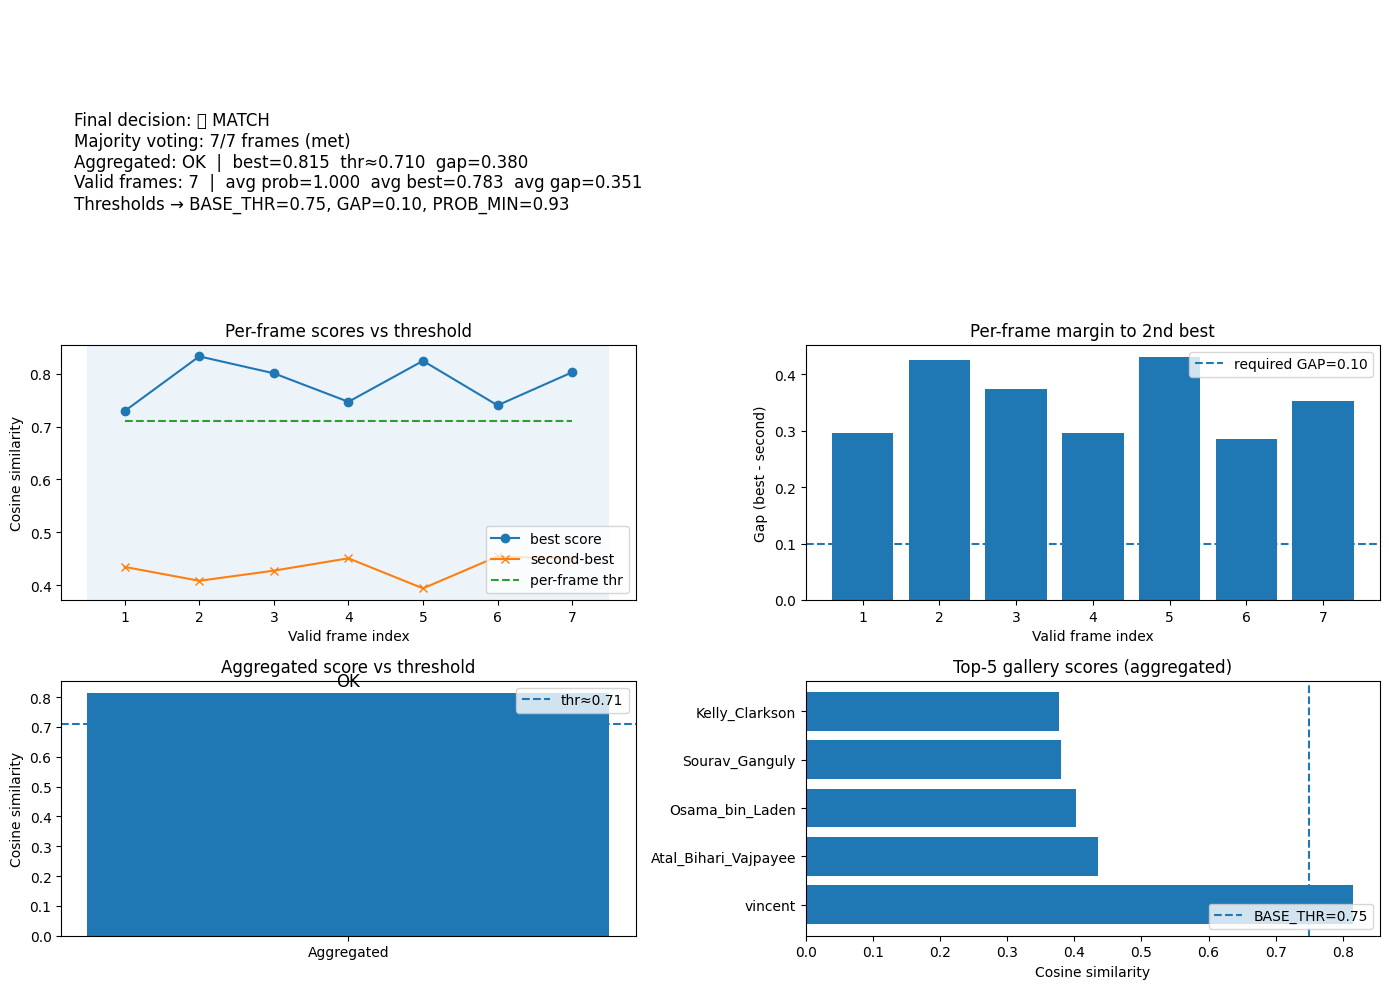

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from math import isnan

# ---------- Helpers ----------
def _recompute_per_frame(embeds, people, base_thr, gap):
    """Run match() on each valid frame embedding to get per-frame stats."""
    frames = []
    for idx, (e, pr) in enumerate(embeds, 1):
        okm, name, best, second, thr = match(e, people, base_thr, gap)
        frames.append({
            "i": idx, "best": float(best), "second": float(second),
            "gap": float(best - second), "thr": float(thr),
            "name": name, "ok": bool(okm), "prob": float(pr),
        })
    return frames

def _topk_gallery_scores(emb, people, k=5):
    """Scores of aggregated emb vs all gallery centroids; return top-k list of dicts."""
    if emb is None or np.isnan(emb).any(): 
        return []
    out = []
    for g in people:
        s = float(np.dot(emb, g["centroid"]))
        out.append({"name": g["name"], "score": s, "spread": float(g.get("spread",0.0)), "n": int(g.get("n", 0))})
    out.sort(key=lambda d: d["score"], reverse=True)
    return out[:min(k, len(out))]

def _safe(v, default=None):
    try:
        return v
    except Exception:
        return default

# ---------- Pull session vars (safe) ----------
valid_embeds  = _safe(valid_embeds, [])
people        = _safe(people, [])
BASE_THR      = float(_safe(BASE_THR, 0.75))
GAP           = float(_safe(GAP, 0.10))
agg_ok        = bool(_safe(agg_ok, False))
best_a        = float(_safe(best_a, np.nan))
second_a      = float(_safe(second_a, np.nan))
thr_a         = float(_safe(thr_a, np.nan))
final_ok      = bool(_safe(final_ok, False))
matches       = int(_safe(matches, 0))
VOTE_TARGET   = int(_safe(VOTE_TARGET, 0))
RELAX_PROB_MIN= float(_safe(RELAX_PROB_MIN, np.nan))
PROB_MIN      = float(_safe(PROB_MIN, np.nan))

# ---------- Recompute per-frame details ----------
frames = _recompute_per_frame(valid_embeds, people, BASE_THR, GAP)
n_valid = len(frames)
xs = np.arange(1, n_valid+1)

# ---------- Layout ----------
ncols = 2 if n_valid >= 1 else 1
fig = plt.figure(figsize=(14, 10 if n_valid>=1 else 4))

row = 0

# (A) Session stats panel (as text)
axA = plt.subplot2grid((3, ncols), (row, 0), colspan=ncols)
axA.axis("off")

avg_prob = np.mean([f["prob"] for f in frames]) if n_valid else float("nan")
avg_best = np.mean([f["best"] for f in frames]) if n_valid else float("nan")
avg_gap  = np.mean([f["gap"]  for f in frames]) if n_valid else float("nan")

summary_lines = [
    f"Final decision: {'✅ MATCH' if final_ok else '❌ NO MATCH'}",
    f"Majority voting: {matches}/{VOTE_TARGET} frames {'(met)' if matches>=VOTE_TARGET else '(not met)'}",
    f"Aggregated: {'OK' if agg_ok else 'NO'}  |  best={best_a:.3f}  thr≈{thr_a:.3f}  gap={best_a-second_a:.3f}" if not (isnan(best_a) or isnan(thr_a)) else "Aggregated: —",
    f"Valid frames: {n_valid}  |  avg prob={avg_prob:.3f}  avg best={avg_best:.3f}  avg gap={avg_gap:.3f}" if n_valid else "Valid frames: 0",
    f"Thresholds → BASE_THR={BASE_THR:.2f}, GAP={GAP:.2f}" + (f", PROB_MIN={PROB_MIN:.2f}" if not isnan(PROB_MIN) else ""),
]
axA.text(0.01, 0.6, "\n".join(summary_lines), fontsize=12, va="top")

row += 1

if n_valid >= 1:
    # (B) Per-frame scores timeline
    axB = plt.subplot2grid((3, ncols), (row, 0))
    bests   = np.array([f["best"]   for f in frames])
    seconds = np.array([f["second"] for f in frames])
    thrs    = np.array([f["thr"]    for f in frames])
    oks     = np.array([1 if f["ok"] else 0 for f in frames])

    axB.plot(xs, bests, marker='o', label="best score")
    axB.plot(xs, seconds, marker='x', label="second-best")
    axB.plot(xs, thrs, linestyle='--', label="per-frame thr")
    # Shade frames that passed
    for i in range(n_valid):
        if oks[i]:
            axB.axvspan(xs[i]-0.5, xs[i]+0.5, alpha=0.08)
    axB.set_title("Per-frame scores vs threshold")
    axB.set_xlabel("Valid frame index")
    axB.set_ylabel("Cosine similarity")
    axB.legend(loc="lower right")

    # (C) Gap vs required margin
    axC = plt.subplot2grid((3, ncols), (row, 1))
    gaps = bests - seconds
    axC.bar(xs, gaps)
    axC.axhline(y=GAP, linestyle='--', label=f"required GAP={GAP:.2f}")
    axC.set_title("Per-frame margin to 2nd best")
    axC.set_xlabel("Valid frame index")
    axC.set_ylabel("Gap (best - second)")
    axC.legend(loc="upper right")

    row += 1

    # (D) Aggregated vs threshold bar + (E) Top-5 gallery scores from aggregated
    axD = plt.subplot2grid((3, ncols), (row, 0))
    if not (isnan(best_a) or isnan(thr_a)):
        axD.bar(["Aggregated"], [best_a])
        axD.axhline(y=thr_a, linestyle='--', label=f"thr≈{thr_a:.2f}")
        axD.set_title("Aggregated score vs threshold")
        axD.set_ylabel("Cosine similarity")
        axD.legend()
        # annotate pass/fail
        axD.text(0, best_a + 0.01, "OK" if agg_ok else "NO", ha="center", va="bottom", fontsize=12)
    else:
        axD.text(0.05, 0.5, "No aggregated score available", transform=axD.transAxes)
        axD.set_axis_off()

    axE = plt.subplot2grid((3, ncols), (row, 1))
    # Build aggregated embedding to rank gallery (approximate by re-averaging valid_embeds)
    emb_agg = None
    if len(valid_embeds) >= 2:
        ws = np.array([pr for _, pr in valid_embeds], dtype=np.float32)
        es = np.stack([e for e, _ in valid_embeds], axis=0)
        w = ws / (ws.sum() + 1e-12)
        emb_agg = (w[:, None] * es).sum(axis=0)
        emb_agg = emb_agg / (np.linalg.norm(emb_agg) + 1e-12)

    topk = _topk_gallery_scores(emb_agg, people, k=5)
    if len(topk) >= 1:
        names = [d["name"] for d in topk]
        vals  = [d["score"] for d in topk]
        axE.barh(np.arange(len(vals))[::-1], vals[::-1])
        axE.axvline(x=BASE_THR, linestyle='--', label=f"BASE_THR={BASE_THR:.2f}")
        axE.set_yticks(np.arange(len(vals))[::-1], labels=names[::-1])
        axE.set_title("Top-5 gallery scores (aggregated)")
        axE.set_xlabel("Cosine similarity")
        axE.legend(loc="lower right")
    else:
        axE.text(0.05, 0.5, "Not enough valid frames to rank gallery", transform=axE.transAxes)
        axE.set_axis_off()

plt.tight_layout()
plt.show()
# ==========================================================================

